In [1]:
import itertools
import math 
import os

from tifffile import imsave
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import xml.etree.ElementTree as ET

from matplotlib.path import Path
from PIL import Image
from sklearn.model_selection import train_test_split

import sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import lidc_helpers

# Inspect DICOM Images

Below is an example of loading a standard dicom image file with pydicom. Note: 
1. Loading an image with pydicom: $\texttt{ds = pydicom.dcmread(path)}$
2. Image unique identifier: the unique image identifer in the DICOM header (0008, 0018)
3. The actual image data: ds.pixel_array

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.278631323634593956582096991980
(0008, 0020) Study Date                          DA: '20000101'
(0008, 0021) Series Date                         DA: '20000101'
(0008, 0022) Acquisition Date                    DA: '20000101'
(0008, 0023) Content Date                        DA: '20000101'
(0008, 0024) Overlay Date                        DA: '20000101'
(0008, 0025) Curve Date                          DA: '20000101'
(0008, 002a) Acquisition DateTime                DT: '20000101'
(0008, 0030) Study Time                          TM: ''
(0008, 0032) Acquisition Time                    TM: ''
(0008, 0033) Content Time                        TM: ''
(0008, 0050) Accession Number               

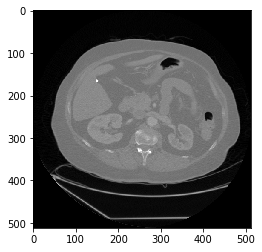

In [2]:
# ds = pydicom.dcmread('raw_data/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/000001.dcm')
ds = pydicom.dcmread('raw_data/LIDC-IDRI/LIDC-IDRI-0004/01-01-2000-91780/3000534-58228/000001.dcm')

print(ds)

plt.imshow(ds.pixel_array, vmin=0, vmax=2048, cmap='gray') 
plt.show()

# Find the Path to CT Images 
Given a patient ID, the code below returns the path to the directory containing their CT images

In [3]:
ct_path = lidc_helpers.find_ct_path('raw_data/LIDC-IDRI/', 'LIDC-IDRI-0002')


# Find the UID of Images 

The code below creates a pandas DataFrame of UIDs for all CT images for a given patient

In [4]:
df_path = lidc_helpers.get_uids_df(ct_path)
df_path.head()

,z-position,path
UID,,
1.3.6.1.4.1.14519.5.2.1.6279.6001.755365469658840574112120162185,-334.50,raw_data/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-9...
1.3.6.1.4.1.14519.5.2.1.6279.6001.222332792183549200579593266316,-333.25,raw_data/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-9...
1.3.6.1.4.1.14519.5.2.1.6279.6001.637153638660557751394456708509,-332.00,raw_data/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-9...
1.3.6.1.4.1.14519.5.2.1.6279.6001.278711607577414159074138118217,-330.75,raw_data/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-9...
1.3.6.1.4.1.14519.5.2.1.6279.6001.320399999470429148823447135376,-329.50,raw_data/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-9...


# Get Image ROIS 

The contours for the "regions of interest" for tumors are included in the XML file within the image sequence directory. The code below extracts all contours available for a patient and stores them in a dictionary. 
- Keys: UIDs (same as the image path dictionary above)
- Values: 4 lists of tuples (x,y) of points included in the tumor boundary

*Note:* some of the data also included points that were explicity marked as *not* part of nodules, but could typically be confused as such. For our purposes, we ignored this data. 

In [5]:
df_rois = lidc_helpers.get_rois_df(ct_path)
df_rois

,ROIs
UID,
1.3.6.1.4.1.14519.5.2.1.6279.6001.215046240157258276988020089262,"[[(351, 375), (352, 374), (353, 374), (354, 37..."
1.3.6.1.4.1.14519.5.2.1.6279.6001.210219748240103156791231130739,"[[(349, 375), (350, 374), (351, 374), (352, 37..."


# Create Summarizing DataFrame

In [6]:
df_patient = lidc_helpers.get_patient_df_v2('raw_data/LIDC-IDRI/', 'LIDC-IDRI-0004')
df_patient

,UID,z-position,path,ROIs
74,1.3.6.1.4.1.14519.5.2.1.6279.6001.153759531653...,-232.50,raw_data/LIDC-IDRI/LIDC-IDRI-0004/01-01-2000-9...,"[[(140, 319), (139, 320), (140, 321), (140, 32..."
75,1.3.6.1.4.1.14519.5.2.1.6279.6001.175159594489...,-231.25,raw_data/LIDC-IDRI/LIDC-IDRI-0004/01-01-2000-9...,"[[(140, 319), (139, 320), (139, 321), (139, 32..."
76,1.3.6.1.4.1.14519.5.2.1.6279.6001.226269353909...,-230.00,raw_data/LIDC-IDRI/LIDC-IDRI-0004/01-01-2000-9...,"[[(140, 320), (139, 321), (139, 322), (140, 32..."
77,1.3.6.1.4.1.14519.5.2.1.6279.6001.203766013809...,-228.75,raw_data/LIDC-IDRI/LIDC-IDRI-0004/01-01-2000-9...,"[[(140, 320), (139, 321), (139, 322), (139, 32..."


# Get Masks

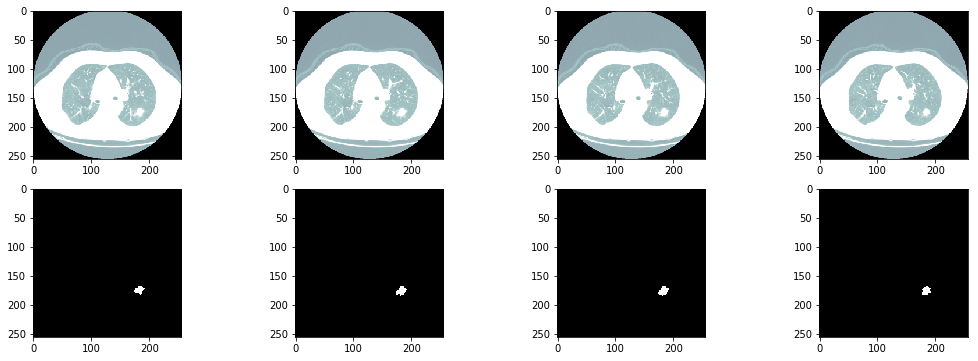

In [10]:
from data_downloader import im_norm

image = np.array([
    pydicom.dcmread(p).pixel_array 
    for p in lidc_helpers.get_patient_df_v2('raw_data/LIDC-IDRI/', 'LIDC-IDRI-0003')['path']
])
rois = list(lidc_helpers.get_patient_df_v2('raw_data/LIDC-IDRI/', 'LIDC-IDRI-0003')['ROIs'])
mask = np.array([lidc_helpers.get_mask(im, roi) for im, roi in zip(image, rois)])

image = im_norm(image)
mask = im_norm(mask, norm=False)

fig, axs = plt.subplots(2, 4, figsize=(18, 6))

for i in range(4):
    axs[0][i].imshow(image[i], cmap='bone')
    axs[1][i].imshow(mask[i], cmap='bone')
plt.show()